# Conditional GANs - Pix2Pix by `Mr. Harshit Dawar!`
* Can be used to generate the classes conditionally, i.e., we have the control over which classes we want to generate!
* It takes paired dataset as the input (source & target image pair).

In [1]:
# Importing the required libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers as ly
import tensorflow as tf
import os
import time
from IPython import display
import pathlib

## Downlaoding the dataset & visualizing a random Image!

In [2]:
dataset_url = "http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz"

In [3]:
# dataset_directory = tf.keras.utils.get_file(fname = "maps.tar.gz", origin = dataset_url, extract = True) = "/c/Users/harsh/.keras/datasets" 
dataset_directory = "C:/Users/harsh/.keras/datasets/maps" 

In [4]:
# Creating a path object
dataset_path = pathlib.Path(dataset_directory)

In [5]:
# Checking the directory in the dataset downloaded
os.listdir(os.path.join(dataset_path.parent, "maps"))

['train', 'val']

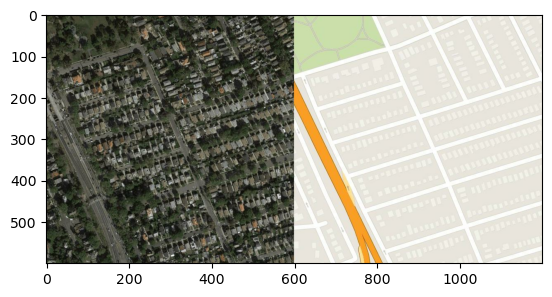

(600, 1200, 3)


In [6]:
# Reading a rando training image
image = tf.io.read_file(os.path.join(os.path.join(dataset_path.parent, "maps/train"), np.random.choice(os.listdir(os.path.join(dataset_path.parent, "maps/train")))))
image = tf.io.decode_jpeg(image)
plt.imshow(image)
plt.show()
print(image.shape)

## Defining the Data Processing Functions & Visualizing data from them

In [7]:
# Function to laod & transform the image
def image_loader(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, [256, 512])    # This size for pix2pix compatibility
    
    # Taking half width to separate the image into satellite & map one
    width = image.shape[1] // 2
    
    satellite_image = image[:, : width, :]
    map_image = image[:, width :, :]
    
    satellite_image = tf.cast(satellite_image, tf.float32)
    map_image = tf.cast(map_image, tf.float32)
    
    return satellite_image, map_image

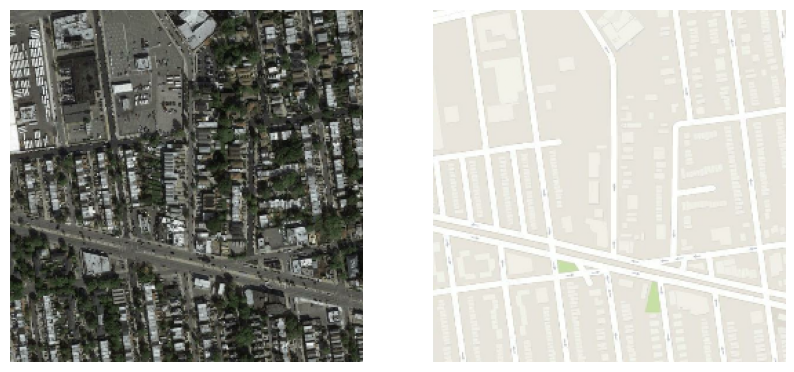

In [8]:
# Visualizing the transformed images 
satellite_image, map_image = image_loader(os.path.join(os.path.join(dataset_path.parent, "maps/train"), np.random.choice(os.listdir(os.path.join(dataset_path.parent, "maps/train")))))
fig, ax = plt.subplots(1, 2, figsize = (10, 9))

ax[0].imshow(satellite_image / 255.0)
ax[1].imshow(map_image / 255.0)
ax[0].axis("off")
ax[1].axis("off")
plt.show()

In [9]:
# Function to resize the images
def resize_image(satellite_image, map_image, width, height):
    satellite_image = tf.image.resize(satellite_image, [width, height], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    map_image = tf.image.resize(map_image, [width, height], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return satellite_image, map_image

# Function to randomly crop the images
def random_crop_image(satellite_image, map_image, width, height):
    stacked_image = tf.stack([satellite_image, map_image], axis = 0)
    cropped_image = tf.image.random_crop(stacked_image, size = [2, width, height, 3])
    return cropped_image[0], cropped_image[1]

# Funciton to add random changes in the image
def add_random_jitter(satellite_image, map_image):
    satellite_image, map_image = resize_image(satellite_image, map_image, 256, 256)
    satellite_image, map_image = random_crop_image(satellite_image, map_image, 256, 256)
    
    # Randomly flipping 30% of the images left to right
    if tf.random.uniform(()) >= 0.7:
        satellite_image = tf.image.flip_left_right(satellite_image)
        map_image = tf.image.flip_left_right(map_image)
    
    return satellite_image, map_image

# Function to normalize the images
def normalize_image(satellite_image, map_image):
    satellite_image = ( satellite_image - 127.5 ) / 127.5
    map_image = ( map_image - 127.5 ) / 127.5
    return satellite_image, map_image

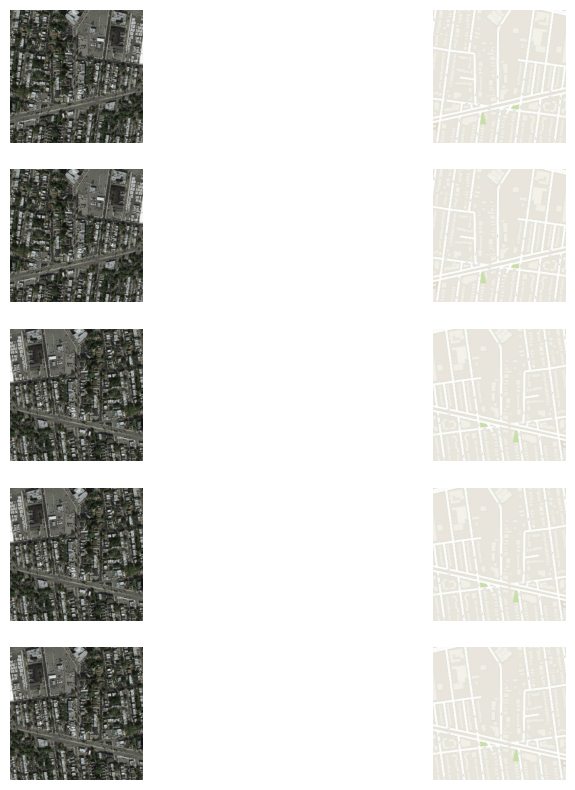

In [10]:
fig, ax = plt.subplots(5, 2, figsize = (10, 10))
for i in range(5):
    si, mi = add_random_jitter(satellite_image, map_image)
    plt.subplot(5, 2, i + 1)
    ax[i][0].imshow(si / 255.0)
    ax[i][1].imshow(mi / 255.0)
    ax[i][0].axis("off")
    ax[i][1].axis("off")
plt.show()

## Loading the dataset

In [11]:
# Function to load & process the training data/images
def load_training_data_and_process_it(image):
    satellite_image, map_image = image_loader(image)
    satellite_image, map_image = add_random_jitter(satellite_image, map_image)
    satellite_image, map_image = normalize_image(satellite_image, map_image)
    return satellite_image, map_image

# Function to load & process the testing data/images
def load_testing_data_and_process_it(image):
    satellite_image, map_image = image_loader(image)
    satellite_image, map_image = resize_image(satellite_image, map_image, 256, 256)
    satellite_image, map_image = normalize_image(satellite_image, map_image)
    return satellite_image, map_image

In [12]:
total_number_of_training_images = len(list(tf.data.Dataset.list_files(os.path.join(dataset_path.parent / "maps/train/*.jpg"))))
batch_size = 1

In [13]:
total_number_of_training_images

1096

In [14]:
# Loading the training data
training_data = tf.data.Dataset.list_files(os.path.join(dataset_path.parent / "maps/train/*.jpg"))
training_data = training_data.map(load_training_data_and_process_it, num_parallel_calls = tf.data.AUTOTUNE)

"""
Using shuffle so that the training data is shuffled & in case their exists some patterns in the training data due to which our model can overfit, those scenarios are eliminated
"""
training_data = training_data.shuffle(total_number_of_training_images)     
training_data = training_data.batch(batch_size)

In [15]:
testing_dataset = tf.data.Dataset.list_files(os.path.join(dataset_path.parent / "maps/val/*.jpg"))
testing_dataset = testing_dataset.map(load_testing_data_and_process_it, num_parallel_calls = tf.data.AUTOTUNE)
testing_dataset = testing_dataset.batch(batch_size)

## Building the Generator!
* The Generator used by Pix2Pix follows the architecture of U-NET
    * It has 2 components:
        * Encoder -> Downsampler
            * It follows the architecture as: Convolutional Layer -> Batch Normalization -> LeakyRelu
        * Decoder -> UpSampler
            * It follows the architecture as: Transposed Convolution -> Batch Normalization -> DropOut -> ReLU

### Building Encoder -> DownSampler

In [16]:
def encoder(filters, kernel_size):
    # Encoder for the Generator
    random_initializer = tf.random_normal_initializer(0., 0.03)     # Random Weights Initializer
    
    model = tf.keras.Sequential()
    model.add(ly.Conv2D(filters, kernel_size, strides = (2, 2), padding = "same", kernel_initializer = random_initializer, use_bias = False))
    model.add(ly.BatchNormalization())
    model.add(ly.LeakyReLU())
    
    return model

In [17]:
satellite_image.shape

TensorShape([256, 256, 3])

In [18]:
downsampler_model = encoder(3, 3)
dsr = downsampler_model(tf.expand_dims(satellite_image, 0))
dsr.shape

TensorShape([1, 128, 128, 3])

### Building Decoder -> Upsampler

In [19]:
def decoder(filters, kernel_size):
    # Decoder for the Generator
    random_initializer = tf.random_normal_initializer(0., 0.03)     # Random Weights Initializer
    
    model = tf.keras.Sequential()
    model.add(ly.Conv2DTranspose(filters, kernel_size, kernel_initializer = random_initializer, padding = "same", strides = (2, 2), use_bias = False))
    model.add(ly.BatchNormalization())
    model.add(ly.Dropout(0.3))
    model.add(ly.ReLU())
    
    return model

In [20]:
upsampler_model = decoder(3, 3)
usr = upsampler_model(dsr)
usr.shape

TensorShape([1, 256, 256, 3])

### Building the Generator

In [21]:
def Generator():
    inputs = tf.keras.layers.Input(shape = [256, 256, 3])
    
    # Creating U-NET structure for pix2pix
    downsampler = [
                    encoder(64, 3),    # shape output after this layer -> (batch_szie, 128, 128, 64)
                    encoder(128, 3),    # shape output after this layer -> (batch_szie, 64, 64, 128)
                    encoder(256, 3),    # shape output after this layer -> (batch_szie, 32, 32, 256)
                    encoder(512, 3),    # shape output after this layer -> (batch_szie, 16, 16, 512)
                    encoder(512, 3),    # shape output after this layer -> (batch_szie, 8, 8, 512)
                    encoder(512, 3),    # shape output after this layer -> (batch_szie, 4, 4, 512)
                    encoder(512, 3),    # shape output after this layer -> (batch_szie, 2, 2, 512)
                    encoder(512, 3),    # shape output after this layer -> (batch_szie, 1, 1, 512)
    ]
    
    upsampler = [
                    decoder(512, 3),          # shape output after this layer -> (batch_size, 2, 2, 512)
                    decoder(512, 3),          # shape output after this layer -> (batch_size, 4, 4, 512)
                    decoder(512, 3),          # shape output after this layer -> (batch_size, 8, 8, 512)
                    decoder(512, 3),          # shape output after this layer -> (batch_size, 16, 16, 512)
                    decoder(256, 3),          # shape output after this layer -> (batch_size, 32, 32, 256)
                    decoder(128, 3),          # shape output after this layer -> (batch_size, 64, 64, 128)
                    decoder(64, 3),          # shape output after this layer -> (batch_size, 128, 128, 64)
    ]
    
    output_channels = 3
    kernel_initializer = tf.random_normal_initializer(0., 0.02)
    
    # shape output after this layer -> (batch_size, 256, 256, 3) -> This is same as the input image. Therefore, the encoder input & decoder output is same.
    final_layer = ly.Conv2DTranspose(output_channels, 3, strides = (2, 2), padding = "same", kernel_initializer = kernel_initializer, activation = "tanh")
    
    # Combining & Creating the model having architecture similar to U-NET
    x = inputs
    skip_connections = []
    
    for downsampling_layer in downsampler:
        x = downsampling_layer(x)
        skip_connections.append(x)
        
    skip_connections = reversed(skip_connections[ : -1]) # Reversing the skip connections as the last one is not required according to the architecture because it just contains one flat layer
    
    
    for upsampling_layer, skip_connection_layer in zip(upsampler, skip_connections):
        x = upsampling_layer(x)
        x = ly.Concatenate()([x, skip_connection_layer])
        
    x = final_layer(x)
    
    return tf.keras.Model(inputs, x)
    


(process:21244): GLib-GIO-WARNING **: 15:03:24.733: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2303.17.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs



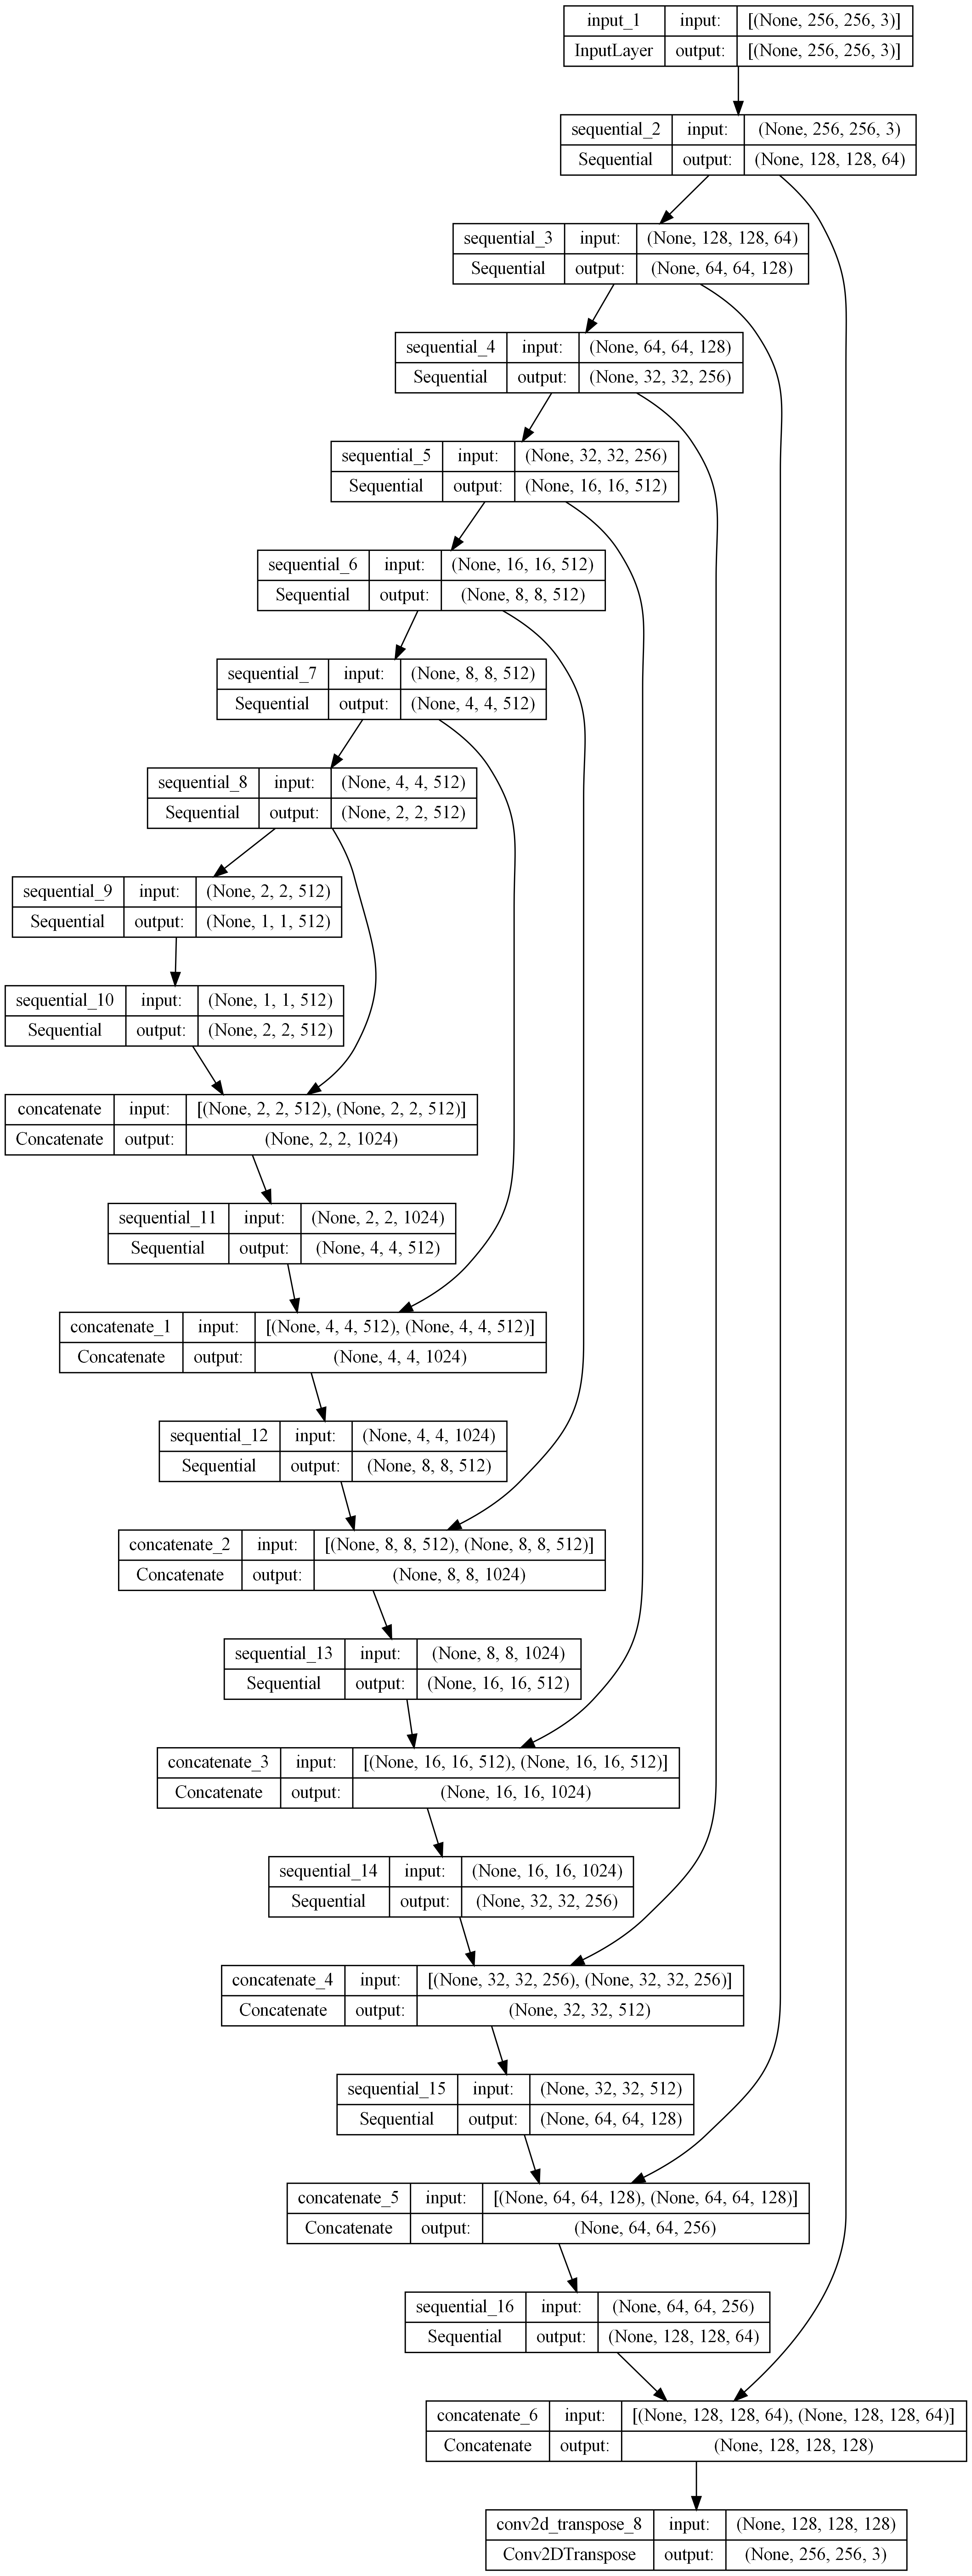

In [22]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes = True, dpi = 300, to_file = "pix2pix-generator.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


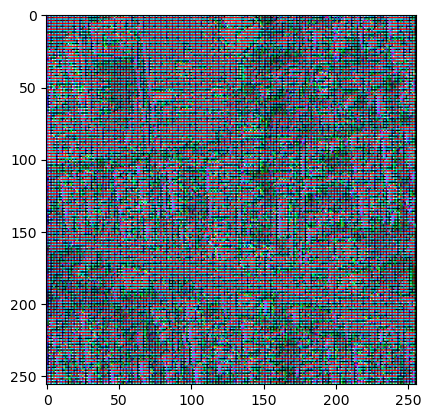

In [26]:
generator_output = generator(satellite_image[tf.newaxis, ...], training = False)
plt.imshow(generator_output[0])
plt.show()

**Sicne the model is not trained, that is why we are getting this type of output. But still, we can see that even without training, we have the dense area captured to a very good extent from the original satellite image!**

## Generator Loss
* In Normal GANs, the loss is adapted from the data which is then leanred/updated by the normal GANs. Whereas, in the Conditional GANs, they learn from the structured loss that a penalizes the structure that differes from the original structure/real image.

**Hyperparameters used in the loss of the conditional GANs**
* Learning Rate -> 0.0002
* Beta1 (Part of Momentum) -> 0.5
* Beta2 (Part of Momentum) -> 0.999
* Lambda -> 100

***Note: pix2pix GANS uses 2 different losses, which is then added to form the total loss. The 2 different losses are as follows***:
1. Generator/GAN Loss: It is binary crossentropy of the discriminator generated imagaes and the array of 1's (Same as it is in DCGANs)
2. L1 Loss: MAE of the generated images and the real images. This ensures that the geenrated images become more similar to the real ones.

***Equation for the Total Loss -> Gan Loss + (Lambda * L1_Loss)***

In [28]:
lambda_ = 100
lr = 0.0002
beta1, beta2 = 0.5, 0.999
bce = tf.keras.losses.BinaryCrossentropy(from_logits = True) # as the output of the generator is in logits form instead of probabilites

In [29]:
def generator_loss(discriminator_generated_output, generator_output, real_output):
    gen_loss = bce(tf.ones_like(discriminator_generated_output), discriminator_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(generator_output, real_output))
    total_loss = gen_loss + (lambda_ * l1_loss)
    return total_loss